# Packages

## Install POT

In [1]:
!pip install POT
!pip install --upgrade numpy

Requirement already up-to-date: numpy in /opt/anaconda3/lib/python3.8/site-packages (1.22.2)


## Install gudhi + optmizer packages

In [ ]:
!pip install gudhi

     |████████████████████████████████| 29.3 MB 1.4 MB/s 


In [ ]:

!pip install tensorflow_addons
!pip install git+https://github.com/master/tensorflow-riemopt.git

     |████████████████████████████████| 1.1 MB 5.3 MB/s 
  Cloning https://github.com/master/tensorflow-riemopt.git to /tmp/pip-req-build-tdrgndo0
  Running command git clone -q https://github.com/master/tensorflow-riemopt.git /tmp/pip-req-build-tdrgndo0
     |████████████████████████████████| 458.3 MB 12 kB/s 
     |████████████████████████████████| 5.6 MB 40.7 MB/s 
     |████████████████████████████████| 14.8 MB 37.3 MB/s 
     |████████████████████████████████| 1.3 MB 27.5 MB/s 
     |████████████████████████████████| 462 kB 55.0 MB/s 
     |████████████████████████████████| 132 kB 28.2 MB/s 
  Created wheel for tensorflow-riemopt: filename=tensorflow_riemopt-0.1.0-py3-none-any.whl size=45244 sha256=7b10fed5ccd1420fddcbb2b26f591e718f1bcf926cc907982feb887ac8d542a5
  Stored in directory: /tmp/pip-ephem-wheel-cache-jt91spdx/wheels/f5/3c/6c/a6eebf4b391b6af4cb01f873345d494c35c02b3883636d1a94
  Created wheel for clang: filename=clang-5.0-py3-none-any.whl size=30694 sha256=d28225e5b3fccf7

In [ ]:
!pip install eagerpy

## Import

In [1]:
import numpy               as np
import tensorflow_addons   as tfa
import tensorflow          as tf
import matplotlib.pyplot   as plt
import pandas              as pd
import gudhi               as gd
import keras.backend as K

from gudhi.wasserstein     import wasserstein_distance
from mpl_toolkits.mplot3d  import Axes3D
from sklearn.metrics       import pairwise_distances


import tensorflow_riemopt as manopt
import ot #pot

#import tensorflow_manopt as manopt <---- didn't work. ??

#from scipy.stats import wasserstein_distance

In [2]:
# import packages
import scipy
from scipy.stats import norm 
import time
import statsmodels.api as sm
import math

In [3]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import normalize
from tensorflow.keras import Sequential, layers, losses
from tensorflow.keras.models import Model

In [12]:
from data_generation import *

## Original Rips Model

In [4]:
def Rips(DX, mel, dim, card):
    # Parameters: DX (distance matrix), 
    #             mel (maximum edge length for Rips filtration), 
    #             dim (homological dimension), 
    #             card (number of persistence diagram points, sorted by distance-to-diagonal)

    # Compute the persistence pairs with Gudhi
    rc = gd.RipsComplex(distance_matrix=DX, max_edge_length=mel)
    st = rc.create_simplex_tree(max_dimension=dim+1)
    dgm = st.persistence()
    pairs = st.persistence_pairs()

    # Retrieve vertices v_a and v_b by picking the ones achieving the maximal
    # distance among all pairwise distances between the simplex vertices
    indices, pers = [], []
    for s1, s2 in pairs:
        if len(s1) == dim+1 and len(s2) > 0:
            l1, l2 = np.array(s1), np.array(s2)
            i1 = [s1[v] for v in np.unravel_index(np.argmax(DX[l1,:][:,l1]),[len(s1), len(s1)])]
            i2 = [s2[v] for v in np.unravel_index(np.argmax(DX[l2,:][:,l2]),[len(s2), len(s2)])]
            indices += i1
            indices += i2
            pers.append(st.filtration(s2) - st.filtration(s1))
    
    # Sort points with distance-to-diagonal
    perm = np.argsort(pers)
    indices = list(np.reshape(indices, [-1,4])[perm][::-1,:].flatten())
    
    # Output indices
    indices = indices[:4*card] + [0 for _ in range(0,max(0,4*card-len(indices)))]
    return list(np.array(indices, dtype=np.int32))

class RipsModel(tf.keras.Model):
    def __init__(self, P, mel=12, dim=1, card=150):
        super(RipsModel, self).__init__()
        self.P = P
        self.mel = mel
        self.dim = dim
        self.card = card
        
    # Question: What is the purpose of this function?
    def call(self):
        m, d, c = self.mel, self.dim, self.card

        #Question: Why are distances being calculcated here? why does gradient keyword show up?

        # Compute distance matrix
        DX = tfa.losses.metric_learning.pairwise_distance(X)
        DXX = tf.reshape(DX, [1, DX.shape[0], DX.shape[1]])
        
        # Turn numpy function into tensorflow function
        XRipsTF = lambda DX: tf.numpy_function(Rips, [DX, m, d, c], [tf.int32 for _ in range(4*c)])
        
        # Compute vertices associated to positive and negative simplices 
        # Don't compute gradient for this operation
        Xids = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(XRipsTF,DXX,dtype=[tf.int32 for _ in range(4*c)]))
        # Get persistence diagram by simply picking the corresponding entries in the distance matrix
        Xdgm = tf.reshape(tf.gather_nd(DX, tf.reshape(Xids, [2*c,2])), [c,2])


        #Z=X@self.P
        Z=self.P
        # Compute distance matrix
        DZ = tfa.losses.metric_learning.pairwise_distance(Z)
        DZZ = tf.reshape(DZ, [1, DZ.shape[0], DZ.shape[1]])
        
        # Turn numpy function into tensorflow function
        ZRipsTF = lambda DZ: tf.numpy_function(Rips, [DZ, m, d, c], [tf.int32 for _ in range(4*c)])
        
        # Compute vertices associated to positive and negative simplices 
        # Don't compute gradient for this operation
        Zids = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(ZRipsTF,DZZ,dtype=[tf.int32 for _ in range(4*c)]))
        # Get persistence diagram by simply picking the corresponding entries in the distance matrix
        Zdgm = tf.reshape(tf.gather_nd(DZ, tf.reshape(Zids, [2*c,2])), [c,2])
        return (Xdgm,Zdgm)

## Modified RipsModel

In [26]:
def Rips(DX, mel, dim, card):
    # Parameters: DX (distance matrix), 
    #             mel (maximum edge length for Rips filtration), 
    #             dim (homological dimension), 
    #             card (number of persistence diagram points, sorted by distance-to-diagonal)

    # Compute the persistence pairs with Gudhi
    rc = gd.RipsComplex(distance_matrix=DX, max_edge_length=mel)
    st = rc.create_simplex_tree(max_dimension=dim+1)
    dgm = st.persistence()
    pairs = st.persistence_pairs()

    # Retrieve vertices v_a and v_b by picking the ones achieving the maximal
    # distance among all pairwise distances between the simplex vertices
    indices, pers = [], []
    for s1, s2 in pairs:
        if len(s1) == dim+1 and len(s2) > 0:
            l1, l2 = np.array(s1), np.array(s2)
            i1 = [s1[v] for v in np.unravel_index(np.argmax(DX[l1,:][:,l1]),[len(s1), len(s1)])]
            i2 = [s2[v] for v in np.unravel_index(np.argmax(DX[l2,:][:,l2]),[len(s2), len(s2)])]
            indices += i1
            indices += i2
            pers.append(st.filtration(s2) - st.filtration(s1))
    
    # Sort points with distance-to-diagonal
    perm = np.argsort(pers)
    indices = list(np.reshape(indices, [-1,4])[perm][::-1,:].flatten())
    
    # Output indices
    indices = indices[:4*card] + [0 for _ in range(0,max(0,4*card-len(indices)))]
    return list(np.array(indices, dtype=np.int32))

# the right one
class RipsModel(tf.keras.Model):
    def __init__(self, P, mel=12, dim=1, card=150):
        super(RipsModel, self).__init__()
        self.P = P
        self.mel = mel
        self.dim = dim
        self.card = card
        
    # Question: What is the purpose of this function?
    def call(self):
        m, d, c = self.mel, self.dim, self.card

        #Question: Why are distances being calculcated here? why does gradient keyword show up?

        # Compute distance matrix
        DX = tfa.losses.metric_learning.pairwise_distance(X)
        #DXX = tf.reshape(DX, [1, DX.shape[0], DX.shape[1]])
        DXX = tf.expand_dims(DX, axis = 0)

        
        # Turn numpy function into tensorflow function
        XRipsTF = lambda DX: tf.numpy_function(Rips, [DX, m, d, c], [tf.int32 for _ in range(4*c)])
        
        # Compute vertices associated to positive and negative simplices 
        # Don't compute gradient for this operation
        Xids = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(XRipsTF,DXX,dtype=[tf.int32 for _ in range(4*c)]))
        #print("Xids",Xids)
        # Get persistence diagram by simply picking the corresponding entries in the distance matrix
        Xdgm = tf.reshape(tf.gather_nd(DX, tf.reshape(Xids, [2*c,2])), [c,2])


        Z=self.P
        #print("Z",Z)
        # Compute distance matrix
        DZ = tfa.losses.metric_learning.pairwise_distance(Z)
        #DZZ = tf.reshape(DZ, [1, DZ.shape[0], DZ.shape[1]])
        DZZ = tf.expand_dims(DZ, axis = 0)
        
        # Turn numpy function into tensorflow function
        ZRipsTF = lambda DZ: tf.numpy_function(Rips, [DZ, m, d, c], [tf.int32 for _ in range(4*c)])
        
        # Compute vertices associated to positive and negative simplices 
        # Don't compute gradient for this operation
        Zids = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(ZRipsTF,DZZ,dtype=[tf.int32 for _ in range(4*c)]))
        # Get persistence diagram by simply picking the corresponding entries in the distance matrix
        Zdgm = tf.reshape(tf.gather_nd(DZ, tf.reshape(Zids, [2*c,2])), [c,2])
        return (Xdgm,Zdgm)

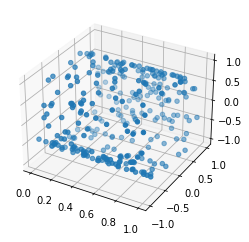

In [5]:
np.random.seed(1) #expand the cylinder into a rectangle and generate 300 points on it and then transform them back
ss3=np.random.uniform(0,2*np.pi,300)
noise=np.random.normal(0,0.1,300) #add noise if you want


noise = 0 #to cancel noise
xx=(1+noise)*np.cos(ss3)
yy=(1+noise)*np.sin(ss3)



rr3=np.random.uniform(0,1,300) #a point (xx,yy,rr3) on 3D
ax = plt.subplot(111, projection='3d')
ax.scatter(rr3,xx,yy) 
X=np.array(np.mat([rr3,xx,yy]).T,dtype=np.float32)
Z=X[:,:2]
plt.show()

In [12]:
class CustomAccuracy1(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    def call(self, X, Y):
        fig, ax = plt.subplots()
        
        ax.scatter(Y.numpy()[:,0],Y.numpy()[:,1])
        plt.show()

        modelR = RipsModel(P=Y, mel=12, dim=1, card = 150)

        #Compute persistence diagram
        Zdgm = modelR.call()[1]
        #sess=tf.compat.v1.InteractiveSession()
        D = Zdgm.numpy()      
        plt.figure()
        plt.scatter(D[:,0], D[:,1], c="blue", alpha=0.8)
        Xdgm = modelR.call()[0]
        D1 = Xdgm.numpy()
        plt.scatter(D1[:,0], D1[:,1],c="orange", alpha=0.5)
        plt.plot([0,0.5],[0,0.5])
        plt.show()



        # Loss is Wasserstein distance

        loss = tf.square(wasserstein_distance(Zdgm, Xdgm, order=2, internal_p=2, enable_autodiff=True))


        return loss

Epoch 1/2


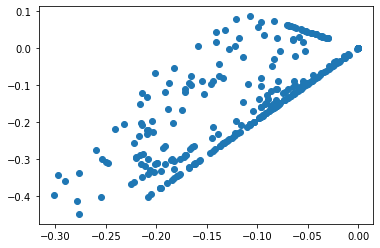

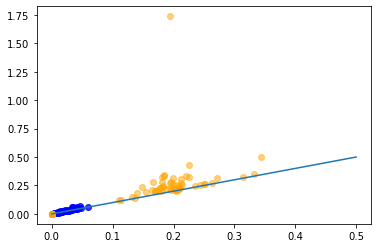

[[0.03444417 0.06337853]
 [0.03399255 0.05685254]
 [0.04060723 0.0611476 ]
 [0.04558505 0.0654784 ]
 [0.03138575 0.04660331]
 [0.03994424 0.05339771]
 [0.02193006 0.03360147]
 [0.01315092 0.02180767]
 [0.01688987 0.02376393]
 [0.02563331 0.03238063]
 [0.03106372 0.03695063]
 [0.04504113 0.05086701]
 [0.04140344 0.04689679]
 [0.03082269 0.03353803]
 [0.04121821 0.04390698]
 [0.01021514 0.01290009]
 [0.03247632 0.03452905]
 [0.01640926 0.01841361]
 [0.02260774 0.0244162 ]
 [0.01088909 0.01246799]
 [0.02672308 0.02801946]
 [0.0201708  0.0214508 ]
 [0.01438851 0.0154666 ]
 [0.01514755 0.01614008]
 [0.02652109 0.02749497]
 [0.03821698 0.03909929]
 [0.02757533 0.02845338]
 [0.01620871 0.01706803]
 [0.02975713 0.03060924]
 [0.05899419 0.05940725]
 [0.00424962 0.00454871]
 [0.02137886 0.02166963]
 [0.0080409  0.00829697]
 [0.02314255 0.02329561]
 [0.04847099 0.04858467]
 [0.01230097 0.01238788]
 [0.00504935 0.00507143]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]


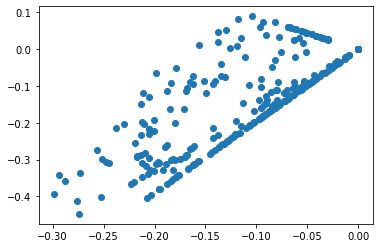

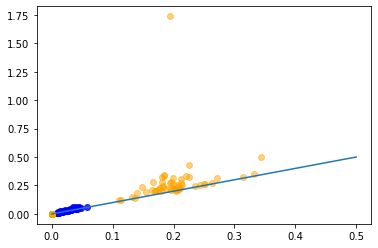

[[0.03454547 0.0608661 ]
 [0.04519306 0.0646279 ]
 [0.03417465 0.05341661]
 [0.03958467 0.05848251]
 [0.03028497 0.04725901]
 [0.03932512 0.05195305]
 [0.02183536 0.03142472]
 [0.01695196 0.02547383]
 [0.01318995 0.02137643]
 [0.0259048  0.03369406]
 [0.0304265  0.03696544]
 [0.04533659 0.05086203]
 [0.04053931 0.04548075]
 [0.00957727 0.01238457]
 [0.01059852 0.01320971]
 [0.03234529 0.03439032]
 [0.04183362 0.04361687]
 [0.01988295 0.02152387]
 [0.03110566 0.03266242]
 [0.02669658 0.02790929]
 [0.02640234 0.0273637 ]
 [0.01099709 0.01181499]
 [0.01546299 0.01627889]
 [0.02253975 0.02333459]
 [0.03827523 0.03906269]
 [0.01766607 0.01844595]
 [0.0213115  0.0217662 ]
 [0.01444613 0.01489558]
 [0.01612807 0.01647587]
 [0.02292226 0.02326681]
 [0.05859222 0.05891204]
 [0.00795309 0.00825082]
 [0.00962577 0.00988072]
 [0.04216199 0.04231614]
 [0.01053029 0.01061433]
 [0.04850494 0.04854624]
 [0.01130024 0.01131787]
 [0.03129289 0.03131002]
 [0.03010017 0.03011057]
 [0.         0.        ]


In [13]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(3, )),
        tf.keras.layers.Dense(3, activation='relu'),
        tf.keras.layers.Dense(2, activation='relu'),
        tf.keras.layers.Dense(2)
        ])
model.compile(loss=CustomAccuracy1(),optimizer = "adam",run_eagerly=True)
model.fit(X, X,epochs=2,batch_size=300)

In [91]:
model.predict(X)

array([[0.2904279 , 0.14221208],
       [0.21706088, 0.10628399],
       [0.44749415, 0.6175674 ],
       [0.5402089 , 0.3459791 ],
       [0.57232225, 0.48608184],
       [0.5727147 , 0.6038315 ],
       [0.68603146, 0.5826583 ],
       [0.47148222, 0.33350962],
       [0.30884328, 0.15123016],
       [0.3195843 , 0.15649007],
       [0.3047422 , 0.14922184],
       [0.17688736, 0.08661087],
       [0.69776106, 0.59262055],
       [0.31544152, 0.43532977],
       [0.30755085, 0.3874154 ],
       [0.19354996, 0.0947706 ],
       [0.29699048, 0.14542581],
       [0.24837714, 0.12161967],
       [0.5637498 , 0.47880104],
       [0.6740701 , 0.57249916],
       [0.08500145, 0.11731369],
       [0.22480798, 0.31025204],
       [0.570353  , 0.4528724 ],
       [0.20190194, 0.09886059],
       [0.30654305, 0.42304954],
       [0.20209645, 0.27890927],
       [0.40586406, 0.34624887],
       [0.3853407 , 0.47427005],
       [0.61986244, 0.52645904],
       [0.25209826, 0.34791368],
       [0.